# Most popular open weights LLMs - December 2023

## Dependencies

In [ ]:
pip install --upgrade datasets

In [ ]:
import flash_attn
flash_attn.__version__

In [ ]:
pip install --upgrade transformers optimum auto-gptq

## Models dictionary

In [1]:
 models = { 
    "tinyllama_1b": "TinyLlama/TinyLlama-1.1B-intermediate-step-1195k-token-2.5T", # 4.10 GB
    "croissantllm_1b" : "croissantllm/CroissantLLMBase", # 5.01 GB
    "stablelm2_1b" : "stabilityai/stablelm-2-1_6b", # 3.06 GB
    "olmo_1b" : "allenai/OLMo-1B", # 4.39 GB
     
    "redpajama_3b" : "togethercomputer/RedPajama-INCITE-Base-3B-v1", # 5.30 GB
    "btlm_3b" : "cerebras/btlm-3b-8k-base", #  4.93 GB
    "openllama2_3b" : "openlm-research/open_llama_3b_v2", #  6.38 GB
    "stablelm_3b" : "stabilityai/stablelm-3b-4e1t", # 5.21 GB
    "phi2_3b" : "microsoft/phi-2", # 5.18 GB
    "minicpm_3b" : "openbmb/MiniCPM-2B-sft-bf16", # 5.08 GB

    "bloomz_7b" : "bigscience/bloomz-7b1-mt", # 13.18 GB
    "falcon_7b" : "tiiuae/falcon-7b", # 13.45 GB       
    "redpajama_7b" : "togethercomputer/RedPajama-INCITE-7B-Base", # 12.90 GB
    "mpt_7b" : "mosaicml/mpt-7b", # 12.39 GB
    "mpt_7b_8k" : "mosaicml/mpt-7b-8k", # 12.39 GB
    "openllama2_7b" : "openlm-research/open_llama_7b_v2", # 12.55 GB
    "llama2_7b" : "meta-llama/Llama-2-7b-hf", # 12.55 GB
    "llama2_7b_32k" : "togethercomputer/LLaMA-2-7B-32K", # 12.55 GB
    "mistral_7b" : "mistralai/Mistral-7B-v0.1", # 13.49 GB
    "qwen_7b" : "Qwen/Qwen-7B", # 14.38 GB
    "yi_6b" : "01-ai/Yi-6B", # 11.29 GB
    "decilm_7b" : "Deci/DeciLM-7B", # 13.12 GB
    "olmo_7b" : "allenai/OLMo-7B", # 25.66 GB
    
    "openllama1_13b" : "openlm-research/open_llama_13b", # 24.24 GB
    "llama2_13b" : "meta-llama/Llama-2-13b-hf", # 24.25 GB
    "qwen_14b" : "Qwen/Qwen-14B", # 26.39 GB
    "solar_10b" : "upstage/SOLAR-10.7B-v1.0", # 19.99 GB
    
    "mpt_30b" : "mosaicml/mpt-30b", # 55.80 GB 
    "codellama_34b" : "codellama/CodeLlama-34b-hf", # 62.86 GB 
    "yi_34b" : "01-ai/Yi-34B", # 64.06 GB    
     
    "falcon_40b" : "tiiuae/falcon-40b", # 77.93 GB
    "alfred_40b": "lightonai/alfred-40b-1023", # 77.93 GB
    "mixtral_8x7B" : "mistralai/Mixtral-8x7B-v0.1" # 86.99 GB
}

## Load dataset

In [2]:
with open("/workspace/hftoken", 'r') as file:
    myhftoken = file.read().strip()

In [3]:
from datasets import load_dataset

In [4]:
#dataset_name_fr = "frenchtext/banque-fr-2311"
#dataset_fr = load_dataset(dataset_name_fr, token=myhftoken)

dataset_name_en = "frenchtext/bank-en-2401"
dataset_en = load_dataset(dataset_name_en, token=myhftoken)

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

In [5]:
dataset_en

DatasetDict({
    train: Dataset({
        features: ['Uri', 'ExtractedFromPDF', 'Timestamp', 'Lang', 'Title', 'Text', 'Words', 'AvgWordsLength', 'Chars', 'LetterChars', 'NumberChars', 'OtherChars'],
        num_rows: 20451
    })
    valid: Dataset({
        features: ['Uri', 'ExtractedFromPDF', 'Timestamp', 'Lang', 'Title', 'Text', 'Words', 'AvgWordsLength', 'Chars', 'LetterChars', 'NumberChars', 'OtherChars'],
        num_rows: 2555
    })
    test: Dataset({
        features: ['Uri', 'ExtractedFromPDF', 'Timestamp', 'Lang', 'Title', 'Text', 'Words', 'AvgWordsLength', 'Chars', 'LetterChars', 'NumberChars', 'OtherChars'],
        num_rows: 2579
    })
})

## Batching and tokenization

In [6]:
dataset_name = dataset_name_en
split = "valid"
dataset = dataset_en[split]

In [7]:
def get_dataset_batches(dataset, batch_size=32):
    filtered_dataset = dataset.filter(lambda example: example["Words"]>15)
    sorted_dataset = filtered_dataset.sort("Words",reverse=True)
    
    dataset_length = len(sorted_dataset)
    for start_idx in range(0, dataset_length, batch_size):
        end_idx = min(start_idx + batch_size, dataset_length)
        yield sorted_dataset[start_idx:end_idx]

In [8]:
def get_encoding_offsets(encoding):
    start_token_idx = 0
    while encoding.special_tokens_mask[start_token_idx]==1: start_token_idx+=1
    start_index = encoding.offsets[start_token_idx][0]
    end_token_idx = len(encoding.offsets)-1
    while encoding.special_tokens_mask[end_token_idx]==1: end_token_idx-=1
    end_index = encoding.offsets[end_token_idx][1]
    return (start_index,end_index)

In [9]:
def encode_dataset_batch(tokenizer, dataset_batch, stride=256):
    
    # SPECIAL CASE: tiktoken tokenizer does not implement truncation=True, return_overflowing_tokens=True, and encodings offsets
    # => we must implement it manually on top of Huggingface tokenizers
    if hasattr(tokenizer,"tokenizer") and tokenizer.tokenizer.__class__.__module__.startswith("tiktoken"):
        encodings = tokenizer(text = dataset_batch["Text"], add_special_tokens=True, 
                      padding="longest", 
                      # 2020: https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#tensor-core-shape
                      # However now in 2023, this is less and less true, newer drivers and cuda versions are smarter about this and will be able to use tensorcores even without this aligned padding
                      pad_to_multiple_of=16, return_tensors="pt")
        
        input_tensor = encodings['input_ids']
        attention_mask = encodings['attention_mask']
       
        batch_size = input_tensor.size(0)
        encodings_length = input_tensor.size(1)
        texts_length = torch.tensor([len(text) for text in dataset_batch["Text"]])
        
        max_length = tokenizer.model_max_length 
        
        if encodings_length > max_length:
        
            unfolded_tensor, overflow_to_sample_mapping = truncate_tensor_with_overflow(input_tensor, padding_value=tokenizer.pad_token_id, max_length=max_length, stride=stride)
            unfolded_mask, _ = truncate_tensor_with_overflow(attention_mask, padding_value=0, max_length=max_length, stride=stride)

            encodings['input_ids'] = unfolded_tensor
            encodings['attention_mask'] = unfolded_mask
            encodings['overflow_to_sample_mapping'] = overflow_to_sample_mapping
            
            offset = max_length - stride
            overflow_lines = 1 + math.ceil((encodings_length - max_length)/offset)
            last_line_padding = overflow_lines*offset + stride - encodings_length
            
            tokens_per_sample = attention_mask.sum(1).tolist()
            start_indexes = []
            end_indexes = []
            for sample_tokens in tokens_per_sample:
                start_indexes.append(torch.clamp(torch.arange(0,overflow_lines*offset,offset), max=sample_tokens)/sample_tokens)
                end_indexes.append(torch.clamp(torch.arange(max_length,encodings_length+last_line_padding+1,offset), max=sample_tokens)/sample_tokens)                
            overflow_to_sample_offset = torch.stack((torch.concat(start_indexes),torch.concat(end_indexes)))

            texts_length_multiplier = torch.repeat_interleave(texts_length, overflow_lines).unsqueeze(0)
            otso = (overflow_to_sample_offset*texts_length_multiplier).int()
            encodings['overflow_to_sample_offset'] = [(otso[0,i].item(),otso[1,i].item()) for i in range(otso.size(1))]
            
        else:
            
            encodings['overflow_to_sample_mapping'] = torch.zeros(batch_size, dtype=torch.int32)
            encodings['overflow_to_sample_offset'] = [(0,texts_length[i].item()) for i in range(batch_size)]
    
    # GENERAL CASE: just rely on Huggingface tokenizers for truncation
    else:
        encodings = tokenizer(text = dataset_batch["Text"], add_special_tokens=True, 
                          padding="longest", truncation=True, return_overflowing_tokens=True, stride=stride,
                          # 2020: https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#tensor-core-shape
                          # However now in 2023, this is less and less true, newer drivers and cuda versions are smarter about this and will be able to use tensorcores even without this aligned padding
                          pad_to_multiple_of=16, return_tensors="pt")

        encodings["overflow_to_sample_offset"] = list(map(get_encoding_offsets, encodings.encodings))
    
    encodings["overflow_to_sample_uri"] = list(map(lambda sample_id: dataset_batch["Uri"][sample_id.item()], encodings["overflow_to_sample_mapping"]))

    return encodings

In [10]:
import math
import torch.nn.functional as F

def truncate_tensor_with_overflow(input_tensor, padding_value, max_length=2048, stride=256):
    batch_length = input_tensor.size(0)
    encoding_length = input_tensor.size(1)

    offset = max_length - stride
    overflow_lines = 1 + math.ceil((encoding_length - max_length)/offset)
    last_line_padding = overflow_lines*offset + stride - encoding_length

    padded_tensor = F.pad(input_tensor, (0,last_line_padding), "constant", padding_value)
    unfolded_tensor = padded_tensor.unfold(1, max_length, offset).reshape(-1, max_length)

    overflow_to_sample_mapping = torch.arange(batch_length).repeat_interleave(overflow_lines)
 
    return unfolded_tensor, overflow_to_sample_mapping 

In [11]:
def get_encodings_batches(tokenizer, dataset, batch_size=32, stride=256):
    for dataset_batch in get_dataset_batches(dataset, batch_size):
        encodings = encode_dataset_batch(tokenizer, dataset_batch, stride)
        
        encodings_length = encodings['input_ids'].size(0)
        for start_idx in range(0, encodings_length, batch_size):
            end_idx = min(start_idx + batch_size, encodings_length)
            yield {key: encodings[key][start_idx:end_idx] for key in encodings.data.keys()}

In [12]:
# Test
#batches_iter = get_dataset_batches(dataset, 2)
#for i in range(0): next(batches_iter)
#dataset_batch=next(batches_iter)

#encodings = encode_dataset_batch(tokenizer, dataset_batch, stride=256)
#encodings

## Load model

In [13]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = list(models)[3]
model_name = models[model_id]
print(f"Computing perplexity on dataset {dataset_name}:{split} for {model_name}")

if model_id=="stablelm2_1b" or model_id=="olmo_1b" or model_id=="olmo_7b":
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
elif model_id=="stablelm_3b":
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=myhftoken)
elif model_id=="qwen_7b" or model_id=="qwen_14b":
    # https://github.com/QwenLM/Qwen/blob/main/tokenization_note.md#special-tokens
    tokenizer = AutoTokenizer.from_pretrained(model_name, cpad_token = '<|endoftext|>', trust_remote_code=True)
elif model_id=="yi_34b":
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    if model_id=="qwen_7b" or model_id=="qwen_14b":
        tokenizer.pad_token = '<|endoftext|>'
    else:
        tokenizer.pad_token = tokenizer.eos_token

if model_id=="tinyllama_1b":
    # torch_dtype="auto" loads the model in fp32, which is not compatible with flash attention
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype=torch.float16, attn_implementation="flash_attention_2")
elif model_id=="croissantllm_1b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=False, device_map="auto", torch_dtype=torch.float16, attn_implementation="flash_attention_2")
elif model_id=="stablelm2_1b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2", trust_remote_code=True)
elif model_id=="olmo_1b":
    # no flash attention support for olmo as of 02/04/2024
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype=torch.float16, attn_implementation="eager")
elif model_id=="olmo_7b":
    # no flash attention support for olmo as of 02/04/2024
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=False, device_map="auto", torch_dtype=torch.float16, attn_implementation="eager")
elif model_id=="btlm_3b":
    # no flash attention support as of 01/07/2024, using device_map triggers a fatal error
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, torch_dtype="auto", attn_implementation="eager", trust_remote_code=True).to('cuda')
    # max context length supported without flahs attention on a RTX 4090
    tokenizer.model_max_length = 4096
elif model_id=="stablelm_3b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2", trust_remote_code=True, token=myhftoken)
elif model_id=="phi2_3b":
    # no flash attention support for phi2 as of 01/07/2024
    # for qwen: latest version of flash_attn installed, but module dropout_layer_norm not found
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="eager", trust_remote_code=True)
elif model_id=="bloomz_7b" or model_id=="mpt_7b":
    # no flash attention support as of 01/08/2024
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="eager")
elif model_id=="decilm_7b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2", trust_remote_code=True)
elif model_id=="openllama1_13b":
    # Chunking error during model conversion to safetensors
    model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2")
elif model_id=="llama2_13b" or model_id=="solar_10b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, load_in_8bit=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2")
elif model_id=="qwen_7b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="eager", trust_remote_code=True)
elif model_id=="qwen_14b":
    # no flash attention support for qwen_14b as of 02/01/2024
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, load_in_8bit=True, device_map="auto", torch_dtype="auto", attn_implementation="eager", trust_remote_code=True)
elif model_id=="mpt_30b":
    # no flash attention support as of 01/18/2024
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=False, load_in_4bit=True, device_map="auto", torch_dtype="auto")
elif model_id=="codellama_34b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, load_in_4bit=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2")
elif model_id=="yi_34b": 
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, load_in_4bit=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2")
elif model_id=="falcon_40b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=False, load_in_4bit=True, device_map=0, torch_dtype="auto", attn_implementation="flash_attention_2")
elif model_id=="alfred_40b":
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=False, trust_remote_code=True, load_in_4bit=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2")
else:
    model = AutoModelForCausalLM.from_pretrained(model_name, use_safetensors=True, device_map="auto", torch_dtype="auto", attn_implementation="flash_attention_2")
    


/workspace/wordslab-llms/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Computing perplexity on dataset frenchtext/bank-en-2401:valid for allenai/OLMo-1B


A new version of the following files was downloaded from https://huggingface.co/allenai/OLMo-1B:
- tokenization_olmo_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Some weights of OLMoForCausalLM were not initialized from the model checkpoint at allenai/OLMo-1B and are newly initialized: ['model.transformer.ff_out.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
free_mem_mb = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0))/1024/1024
print(f"- free memory after load: {free_mem_mb:.2f} MB")

- free memory after load: 22319.00 MB


In [15]:
if model_id=="bloomz_7b":
    tokenizer.model_max_length = model.config.seq_length
elif model_id=="olmo_1b" or model_id=="olmo_7b":
    tokenizer.model_max_length = model.config.max_sequence_length
elif model_id=="mpt_7b" or model_id=="mpt_30b":
    pass
else:
    # IMPORTANT fix: https://github.com/huggingface/transformers/issues/16186
    tokenizer.model_max_length = int(min(tokenizer.model_max_length, model.config.max_position_embeddings))

if model_id=="stablelm2_1b" or model_id=="qwen_7b" or model_id=="qwen_14b" or model_id=="yi_34b":
    print(f"- model vocabulary: {tokenizer.vocab_size}")
else:
    print(f"- model vocabulary: {len(tokenizer.vocab)}")

# Memory limit of RTX 4090
if tokenizer.model_max_length>8192:
    tokenizer.model_max_length = 8192
elif model_id=="decilm_7b" or model_id=="codellama_34b":
    tokenizer.model_max_length = 4096
elif model_id=="mpt_30b":
    tokenizer.model_max_length = 2048
print(f"- model sequence length: {int(tokenizer.model_max_length)}")

print(f"- model torch dtype: {model.dtype}")

- model vocabulary: 50280
- model sequence length: 2048
- model torch dtype: torch.float16


## Unigram-normalized perplexity

https://arxiv.org/pdf/2011.13220.pdf

Unigram-Normalized Perplexity as a Language Model Performance Measure with Different Vocabulary Sizes

*Jihyeon Roh, Sang-Hoon Oh, Soo-Young Lee*

Although Perplexity is a widely used performance metric for language models, the values are highly dependent upon the number of words in the corpus and is useful to compare performance of the same corpus only.

Perplexity may not be suitable for comparing LMs using different vocabularies because a larger vocabulary size tends to result in lower word probabilities and thus a higher Perplexity.

In this paper, we propose a new metric that can be used to evaluate language model performance with different vocabulary sizes. 

The proposed unigram-normalized Perplexity actually presents the performance improvement of the language models from that of simple unigram model, and is robust on the vocabulary size.

To overcome the limitations of the perplexity, we adopt the basic idea of normalizing the word probability with respect to a quantity containing the vocabulary size. 

We apply a unigram probability that is calculated from the word occurrence as a normalization factor for the perplexity. The unigram probability from the unigram LM is computed as Count(vk) / Count(all words), where Count(vk) is the number of occurrences of word vk in the corpus.

Our proposed metric is obtained by normalizing the perplexity with this unigram probability.

The proposed “Perplexity normalized with unigram” (PPLu) is defined as
PPLu = (Product for all words in sequence of : P(word | language model) / P(word | unigram))^1/length of sequence 

This metric shows the likelihood improvement of a context-dependent LM from unigram LM without the context information, and enables us to evaluate the effectiveness of an LM.

PPLu contains a unigram probability term, which allows PPLu to evaluate LMs more accurately than PPL does. Specifically, even if an LM fails to capture word relationships, it may achieve a good PPL by simply assigning high probabilities to words that frequently appear (e.g., unknown tokens). This case can be corrected with our PPLu, which considers the word frequencies via unigram probabilities.

Formula:

``` 
log(PPLu) = 1/length of sequence * Sum for all words in sequence( log(P(word | language model)) - log(P(word | unigram)))
          = Log(PPL) - 1/length of sequence * Sum for all words in sequence( log(P(word | unigram) )
```

**Perplexity = 1 / geometric mean of model token probabilities****1 / geometric mean of model token probabilities**

pt_ppl_losses = [ -ln(prob_model) ]

pt_unigram_losses = [ -ln(prob_unigram) ]

avg_ppl_losses = pt_ppl_losses.sum() / tokens_count 

avg_unigram_losses = pt_unigram_losses.sum() / tokens_count 

ppl = math.exp( avg_ppl_losses ) 

ppl_unigram = math.exp( avg_unigram_losses )

**Unigram-normalized perplexity = (1 / geometric mean of model token probabilities) / (1 / geometric mean of unigram token probabilities)**

pt_pplu_losses = pt_ppl_losses - pt_unigram_losses

avg_pplu_losses = pt_pplu_losses.sum() / tokens_count

pplu = math.exp( avg_pplu_losses )

= math.exp( avg_ppl_losses - avg_unigram_losses ) 

= math.exp( avg_ppl_losses)/math.exp( avg_unigram_losses ) 

= ppl / ppl_unigram

ppl_unigram = ppl / pplu

In [16]:
import torch.nn.functional as F

class PPLu():
    
    def __init__(self, dataset_iterator, tokenizer, device):
        if hasattr(tokenizer,"vocab"):
            self.vocab_size = len(tokenizer.vocab)
        else:
            self.vocab_size = tokenizer.vocab_size
        dataset_token_id_counts = torch.zeros(self.vocab_size+1, dtype=torch.int64)
        dataset_tokens_count = 0
        
        for idx,dataset_batch in enumerate(dataset_iterator):
            encodings = tokenizer(text = dataset_batch["Text"], add_special_tokens=True, padding="longest", return_tensors="pt")
            
            # Padding tokens should be ignored: count them as token_id=vocabulary_size
            token_ids = encodings.input_ids*encodings.attention_mask + self.vocab_size*(1-encodings.attention_mask)
            
            token_id_counts = torch.bincount(token_ids.view(-1), minlength=self.vocab_size+1)
            tokens_count = encodings.attention_mask.sum()

            dataset_token_id_counts += token_id_counts
            dataset_tokens_count += tokens_count
            if idx%100==9: print(f"... {dataset_tokens_count:,} tokens")
        
        # Then discard the tokens count for token_id=vocabulary_size
        self.token_id_probs =  (dataset_token_id_counts[:-1] / dataset_tokens_count).unsqueeze(1).to(device)
        self.perplexity_loss = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction="none")
        print(f"Done: {dataset_tokens_count:,} tokens")

    def __call__(self, input_ids, attention_mask, output_logits):
        # Next-token prediction: shift prediction scores and input ids by one
        logits = output_logits[:, :-1, :].permute(0, 2, 1).contiguous()
        labels = input_ids[:, 1:].contiguous()
        labels_to_ignore = attention_mask[:, 1:]

        # Number of tokens predicted, ignoring padding tokens
        predicted_tokens_count_r = labels_to_ignore.sum(dim=1)
        # ... make sure we don't divide by 0 below ...
        predicted_tokens_count = predicted_tokens_count_r.clamp(min=1)
        
        # Cross entropy loss (ignore_index=-100)
        labels_for_crossentropy = labels*labels_to_ignore -100*(1-labels_to_ignore)
        batch_perplexity_losses = (1/predicted_tokens_count)*self.perplexity_loss(logits, labels_for_crossentropy).sum(1)
        
        # Unigram probability loss
        labels_probs = F.embedding(labels, self.token_id_probs).squeeze()
        # prob = 1 for padding tokens => log prob = 0, ignored in the sum below
        labels_probs = labels_probs*labels_to_ignore + (1-labels_to_ignore) 
        batch_unigram_losses = -(1/predicted_tokens_count)*torch.log(labels_probs).sum(dim=1)
        
        # Unigram-nomralized perplexities
        perplexities = torch.exp(batch_perplexity_losses)
        unigram_normalized_perplexities = torch.exp(batch_perplexity_losses - batch_unigram_losses)
        
        return predicted_tokens_count_r, batch_perplexity_losses, batch_unigram_losses, perplexities, unigram_normalized_perplexities

In [17]:
class NormalizedPerplexityLogger:
    def __init__(self, dataset_name, split, model_name):
        self.filename = f"{dataset_name.replace('/','_')}_{split}_{model_name.replace('/','_')}_pplu.csv"
        self.file = open(self.filename, 'w')
        
    def log_batch(self, ppl, pplu, uri, span):
        self.file.write(f"{ppl},{pplu},{uri},{span}\n")

In [18]:
pplu_loss = PPLu(get_dataset_batches(dataset), tokenizer, model.device)

Token indices sequence length is longer than the specified maximum sequence length for this model (549074 > 2048). Running this sequence through the model will result in indexing errors


... 6,680,615 tokens
Done: 8,530,699 tokens


In [19]:
if model_id=="tinyllama_1b" or model_id=="croissantllm_1b" or model_id=="olmo_1b" or model_id=="redpajama_3b" or model_id=="openllama2_3b":
    batch_size = 16
elif model_id=="redpajama_7b":
    batch_size = 8
elif model_id=="stablelm_3b" or model_id=="phi2_3b" or model_id=="falcon_7b" or model_id=="olmo_7b" or model_id=="mpt_7b"or model_id=="openllama1_13b":
    batch_size = 6
elif model_id=="stablelm2_1b" or model_id=="btlm_3b" or model_id=="llama2_7b":
    batch_size = 4
elif model_id=="yi_6b" or model_id=="llama2_13b":
    batch_size = 3
elif model_id=="bloomz_7b" or model_id=="llama2_7b_32k" or model_id=="mistral_7b"or model_id=="decilm_7b" or model_id=="solar_10b":
    batch_size = 2
elif model_id=="mpt_30b" or model_id=="codellama_34b" or model_id=="yi_34b" or model_id=="qwen_7b" or model_id=="qwen_14b":
    batch_size = 1
stride = 256

print(f"- dataset examples: {len(dataset)}")
print(f"- batch_size={batch_size}, stride={stride}")

- dataset examples: 2555
- batch_size=16, stride=256


In [ ]:
import math

logger = NormalizedPerplexityLogger(dataset_name, split, model_name)

def display_perplexities(pred_tokens_count, ppl_losses, unigram_losses):        
    pt_pred_tokens_count = torch.Tensor(pred_tokens_count)
    total_pred_tokens_count = pt_pred_tokens_count.sum().item()
    
    pt_ppl_losses = torch.Tensor(ppl_losses)
    pt_unigram_losses = torch.Tensor(unigram_losses)    
    pt_pplu_losses = pt_ppl_losses - pt_unigram_losses

    ppl = math.exp((pt_ppl_losses*pt_pred_tokens_count).sum().item() / total_pred_tokens_count)
    pplu = math.exp((pt_pplu_losses*pt_pred_tokens_count).sum().item() / total_pred_tokens_count)

    print(f"-> perplexity = {ppl:.3f}")
    print(f"-> unigram-normalized perplexity = {pplu*1000:.3f} (x1000)")
    
pred_tokens_count = [] 
ppl_losses = []   
unigram_losses = [] 
for idx,encodings_batch in enumerate(get_encodings_batches(tokenizer, dataset, batch_size=batch_size, stride=stride)):       
    with torch.no_grad():
        # predict next token
        inputs = encodings_batch["input_ids"].to(model.device)
        attention_mask = encodings_batch["attention_mask"].to(model.device)
        outputs = model(input_ids=inputs, attention_mask=attention_mask, use_cache=False, output_attentions=False, output_hidden_states=False)

        batch_pred_tokens_count, batch_ppl_losses, batch_unigram_losses, batch_ppl, batch_pplu = pplu_loss(inputs, attention_mask, outputs.logits)
        
        pred_tokens_count.extend(batch_pred_tokens_count.tolist())
        ppl_losses.extend(batch_ppl_losses.tolist())
        unigram_losses.extend(batch_unigram_losses.tolist())

    for ppl,pplu,uri,span in zip(batch_ppl.tolist(), batch_pplu.tolist(), encodings_batch["overflow_to_sample_uri"], encodings_batch["overflow_to_sample_offset"]):
        logger.log_batch(ppl, pplu, uri, span)

    if idx%10 == 0:
        print(f"{(idx+1)*batch_size} encodings processed")
        display_perplexities(pred_tokens_count, ppl_losses, unigram_losses)

print(f"FINAL RESULT: {(idx+1)*batch_size} encodings processed")
display_perplexities(pred_tokens_count, ppl_losses, unigram_losses)

## Visualize 1/PPLu

In [22]:
french_perfs = {
"allenai/OLMo-7B" : { "pplu-1":186, "time":42.85, "size":7, "sequence":2048, "tokens":14.248 },
"bigscience/bloomz-7b1-mt" : { "pplu-1":217, "time":58.86, "size":7.1, "sequence":2048, "tokens":10.041 },
"codellama/CodeLlama-34b-hf [4 bits]" : { "pplu-1":198, "time":220, "size":34, "sequence":4.032, "tokens":15.042 },
"croissantllm/CroissantLLMBase" : { "pplu-1":255, "time":8.5, "size":1.3, "sequence":2048, "tokens":11.181 },
"lightonai/alfred-40b-1023 [4 bits]" : { "pplu-1":244, "time":197, "size":40, "sequence":8192, "tokens":13.622 },
"meta-llama/Llama-2-13b-hf [8 bits]" : { "pplu-1":204, "time":59.31, "size":13, "sequence":4096, "tokens":15.042 },
"meta-llama/Llama-2-7b-hf" : { "pplu-1":189, "time":59.31, "size":7, "sequence":4096, "tokens":15.042 },
"mistralai/Mistral-7B-v0.1" : { "pplu-1":201, "time":40.45, "size":7.3, "sequence":8192, "tokens":15.453 },
"mistralai/Mixtral-8x7B-v0.1 [4 bits]" : { "pplu-1":252, "time":90, "size":46.7, "sequence":8192, "tokens":15.169 },
"mosaicml/mpt-30b [4 bits]" : { "pplu-1":215, "time":252, "size":30, "sequence":2048, "tokens":14.248 },
"mosaicml/mpt-7b" : { "pplu-1":192, "time":51.86, "size":6.7, "sequence":2048, "tokens":14.248 },
"Qwen/Qwen-14B [8 bits]" : { "pplu-1":256, "time":318, "size":14, "sequence":8192, "tokens":13.057 },
"Qwen/Qwen-7B" : { "pplu-1":223, "time":46.76, "size":7, "sequence":8192, "tokens":13.057 },
"stabilityai/stablelm-2-1_6b" : { "pplu-1":211, "time":16.55, "size":1.6, "sequence":4096, "tokens":13.213 },
"stabilityai/stablelm-3b-4e1t" : { "pplu-1":217, "time":14.6, "size":3, "sequence":4096, "tokens":14.248 },
"tiiuae/falcon-7b" : { "pplu-1":214, "time":29.71, "size":7, "sequence":2048, "tokens":13.622 },
"togethercomputer/LLaMA-2-7B-32K" : { "pplu-1":181, "time":36.48, "size":7, "sequence":8192, "tokens":15.034 },
"togethercomputer/RedPajama-INCITE-7B-Base" : { "pplu-1":195, "time":29.51, "size":6.9, "sequence":2048, "tokens":14.248 },
"togethercomputer/RedPajama-INCITE-Base-3B-v1" : { "pplu-1":173, "time":13.86, "size":2.8, "sequence":2048, "tokens":14.248 },
"upstage/SOLAR-10.7B-v1.0 [8 bits]" : { "pplu-1":189, "time":89, "size":10.7, "sequence":4096, "tokens":15.453 }
}

english_perfs = {
"allenai/OLMo-7B" : { "pplu-1":175, "time":25.63, "size":7, "sequence":2048, "tokens":8.53 },
"bigscience/bloomz-7b1-mt" : { "pplu-1":116, "time":44.1, "size":7.1, "sequence":2048, "tokens":8.014 },
"codellama/CodeLlama-34b-hf [4 bits]" : { "pplu-1":152, "time":160, "size":34, "sequence":8192, "tokens":10.523 },
"croissantllm/CroissantLLMBase" : { "pplu-1":154, "time":10.83, "size":1.3, "sequence":2048, "tokens":9.145 },
"lightonai/alfred-40b-1023 [4 bits]" : { "pplu-1":159, "time":142, "size":40, "sequence":8192, "tokens":9.243 },
"meta-llama/Llama-2-13b-hf [8 bits]" : { "pplu-1":168, "time":43.78, "size":13, "sequence":4096, "tokens":10.523 },
"meta-llama/Llama-2-7b-hf" : { "pplu-1":159, "time":26.63, "size":7, "sequence":4096, "tokens":10.523 },
"mistralai/Mistral-7B-v0.1" : { "pplu-1":166, "time":29.11, "size":7.3, "sequence":8192, "tokens":10.159 },
"mistralai/Mixtral-8x7B-v0.1 [4 bits]" : { "pplu-1":178, "time":56.73, "size":46.7, "sequence":8192, "tokens":10.159 },
"mosaicml/mpt-30b [4 bits]" : { "pplu-1":190, "time":136, "size":30, "sequence":2048, "tokens":8.53 },
"mosaicml/mpt-7b" : { "pplu-1":174, "time":31.83, "size":6.7, "sequence":2048, "tokens":8.53 },
"Qwen/Qwen-14B [8 bits]" : { "pplu-1":173, "time":220, "size":14, "sequence":8192, "tokens":8.441 },
"Qwen/Qwen-7B" : { "pplu-1":172, "time":26.68, "size":7, "sequence":8192, "tokens":8.441 },
"stabilityai/stablelm-2-1_6b" : { "pplu-1":140, "time":12.75, "size":1.6, "sequence":4096, "tokens":8.448 },
"stabilityai/stablelm-3b-4e1t" : { "pplu-1":190, "time":8.83, "size":3, "sequence":4096, "tokens":8.53 },
"tiiuae/falcon-7b" : { "pplu-1":130, "time":19.45, "size":7, "sequence":2048, "tokens":9.243 },
"togethercomputer/LLaMA-2-7B-32K" : { "pplu-1":161, "time":27.96, "size":7, "sequence":8192, "tokens":10.52 },
"togethercomputer/RedPajama-INCITE-7B-Base" : { "pplu-1":166, "time":17.3, "size":6.9, "sequence":2048, "tokens":8.53 },
"togethercomputer/RedPajama-INCITE-Base-3B-v1" : { "pplu-1":154, "time":8.18, "size":2.8, "sequence":2048, "tokens":8.53 },
"upstage/SOLAR-10.7B-v1.0 [8 bits]" : { "pplu-1":153, "time":55.86, "size":10.7, "sequence":4096, "tokens":10.159 }
}

In [67]:
models_to_key = { models[key]:key for key in models }
labels = [models_to_key[model.split()[0]] for model in french_perfs]
sizes = [french_perfs[model]["size"]*8 for model in french_perfs]

In [98]:
fr_pplus = [french_perfs[model]["pplu-1"] for model in french_perfs]
fr_times = [french_perfs[model]["time"] for model in french_perfs]
fr_tokens = [french_perfs[model]["tokens"] for model in french_perfs]

In [100]:
en_pplus = [english_perfs[model]["pplu-1"] for model in english_perfs]
en_times = [english_perfs[model]["time"] for model in english_perfs]
en_tokens = [english_perfs[model]["tokens"] for model in english_perfs]

In [105]:
fr_avg_tokens = sum(fr_tokens)/len(fr_tokens)
en_avg_tokens = sum(en_tokens)/len(en_tokens)

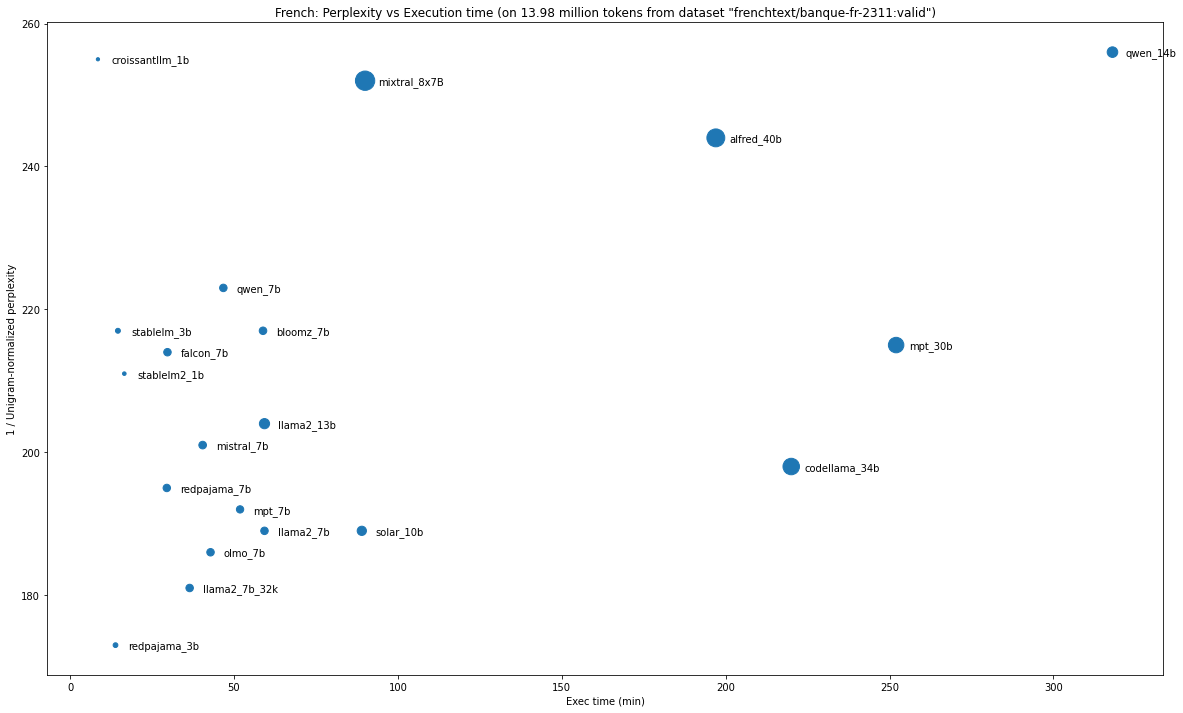

In [111]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(20, 12))
scatter = ax.scatter(fr_times, fr_pplus, s=sizes, alpha=1)

# Adding labels to each point
for i, label in enumerate(labels):
    ax.annotate(label, (fr_times[i]+4, fr_pplus[i]-0.5))

# Setting the axis labels
ax.set_xlabel('Exec time (min)')
ax.set_ylabel('1 / Unigram-normalized perplexity')
ax.set_title(f'French: Perplexity vs Execution time (on {fr_avg_tokens:.2f} million tokens from dataset "frenchtext/banque-fr-2311:valid")')

plt.show()

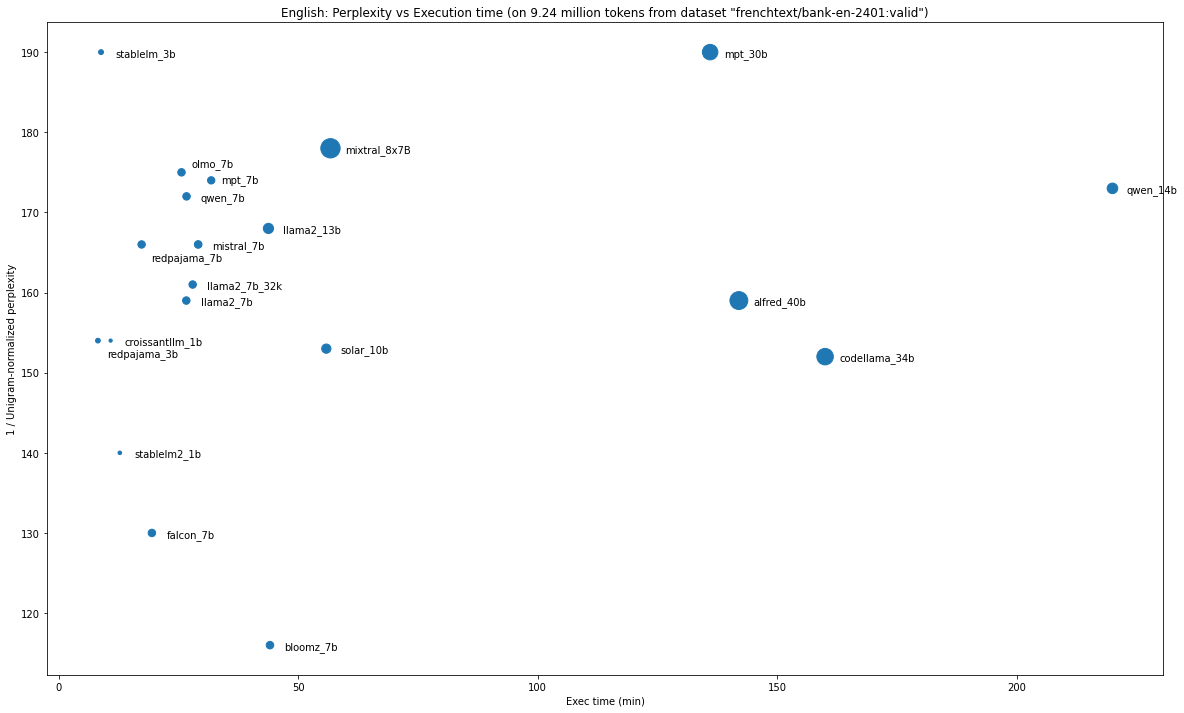

In [110]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 12))
scatter = ax.scatter(en_times, en_pplus, s=sizes, alpha=1)

# Adding labels to each point
for i, label in enumerate(labels):
    if label.startswith("redpajama"):
        ax.annotate(label, (en_times[i]+2, en_pplus[i]-2))
    elif label=="mpt_7b":        
        ax.annotate(label, (en_times[i]+2, en_pplus[i]-0.2))
    elif label=="olmo_7b":        
        ax.annotate(label, (en_times[i]+2, en_pplus[i]+0.7))
    else:
        ax.annotate(label, (en_times[i]+3, en_pplus[i]-0.5))

# Setting the axis labels
ax.set_xlabel('Exec time (min)')
ax.set_ylabel('1 / Unigram-normalized perplexity')
ax.set_title(f'English: Perplexity vs Execution time (on {en_avg_tokens:.2f} million tokens from dataset "frenchtext/bank-en-2401:valid")')

plt.show()

omputing perplexity on dataset frenchtext/bank-en-2401:valid for allenai/OLMo-1B
- free memory after load: 22319.00 MB
- model vocabulary: 50280
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=16, stride=256
- 8,530,699 tokens in 15 sec
- perplexity = 8.268
- unigram-normalized perplexity = 7.325 (x1000)

5 min 58 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for allenai/OLMo-7B
- free memory after load: 11423.50 MB
- model vocabulary: 50280
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=6, stride=256
- 8,530,699 tokens in 22 sec
- perplexity = 6.419
- unigram-normalized perplexity = 5.687 (x1000)

25 min 38 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for allenai/OLMo-7B
- free memory after load: 11423.50 MB
- model vocabulary: 50280
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=6, stride=256
- 14,248,418 tokens in 16 sec
- perplexity = 5.783
- unigram-normalized perplexity = 5.372 (x1000)

42 min 51 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for allenai/OLMo-1B
- free memory after load: 22319.00 MB
- model vocabulary: 50280
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=16, stride=256
- 14,248,418 tokens in 11 sec
- perplexity = 8.421
- unigram-normalized perplexity = 7.823 (x1000)

9 min 57 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for croissantllm/CroissantLLMBase
- free memory after load: 21935.30 MB
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=16, stride=256
- 11,181,671 tokens in 37 sec
- perplexity = 6.300
- unigram-normalized perplexity = 3.921 (x1000)

8 min 30 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for croissantllm/CroissantLLMBase
- free memory after load: 21935.30 MB
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=16, stride=256
- 9,145,900 tokens in 5 min 16 sec
- perplexity = 7.963
- unigram-normalized perplexity = 6.461 (x1000)

10 min 50 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for Qwen/Qwen-7B
- free memory after load: 9832.23 MB
- model vocabulary: 151851
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=1, stride=256
- 8,441,323 tokens tokens in 17 sec
- perplexity = 5.970
- unigram-normalized perplexity = 5.808 (x1000)

26 min 41 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for Qwen/Qwen-14B
- free memory after load: 9507.93 MB
- model vocabulary: 151851
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=1, stride=256
- 8,441,323 tokens in 11 sec
- perplexity = 5.915
- unigram-normalized perplexity = 5.755 (x1000)

3h 40 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for Qwen/Qwen-7B
- free memory after load: 9832.23 MB
- model vocabulary: 151851
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=1, stride=256
- 13,057,768 tokens in 15 sec
- perplexity = 5.413
- unigram-normalized perplexity = 4.466 (x1000)

46 min 46 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for Qwen/Qwen-14B
- free memory after load: 9507.93 MB
- model vocabulary: 151851
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=1, stride=256
- 13,057,768 tokens in 15 sec
- perplexity = 4.723
- unigram-normalized perplexity = 3.897 (x1000)

5 h 18 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for stabilityai/stablelm-2-1_6b
- free memory after load: 21420.82 MB
- model vocabulary: 100289
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- batch_size=4, stride=256
- 13,213,989 tokens in 11 sec
- perplexity = 5.632
- unigram-normalized perplexity = 4.726 (x1000)

16 min 33 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for stabilityai/stablelm-2-1_6b
- free memory after load: 21420.82 MB
- model vocabulary: 100289
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=4, stride=256
- 8,448,894 tokens in 8 sec
- perplexity = 7.291
- unigram-normalized perplexity = 7.097 (x1000)

12 min 45 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for codellama/CodeLlama-34b-hf
- model vocabulary: 32004
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=1, stride=256
- 10,523,047 tokens in 5 min 3 sec
- perplexity = 4.312
- unigram-normalized perplexity = 6.577 (x1000)

2 h 40 min

Computing perplexity on dataset frenchtext/bank-en-2401:valid for 01-ai/Yi-34B
- free memory after load: 4716.67 MB
- model vocabulary: 64000
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=1, stride=256
- 9,943,316 tokens in 4 min 47 sec
- perplexity = 4.054
- unigram-normalized perplexity = 6.919 (x1000)

2 h 46 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for lightonai/alfred-40b-1023
- model vocabulary: 65024
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=4, stride=256
- 13,622,486 tokens in 14 sec
- perplexity = 3.815
- unigram-normalized perplexity = 4.098 (x1000)

3 h 17min

Computing perplexity on dataset frenchtext/bank-en-2401:valid for lightonai/alfred-40b-1023
- model vocabulary: 65024
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=4, stride=256
- 9,243,621 tokens in 14 sec
- perplexity = 4.690
- unigram-normalized perplexity = 6.273 (x1000)

2 h 22 min

Computing perplexity on dataset frenchtext/bank-en-2401:valid for meta-llama/Llama-2-13b-hf
- **load_in_4bit=True**
- free memory after load: 17001.15 MB
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- 10,523,047 tokens in 5 min 4 sec
- dataset examples: 2555
- batch_size=3, stride=256
- perplexity = 3.988
- unigram-normalized perplexity = 6.109 (x1000)

2h 16 min

Computing perplexity on dataset frenchtext/bank-en-2401:valid for mosaicml/mpt-30b
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=1, stride=256
- 8,530,699 tokens in 7 sec
- perplexity = 5.918
- unigram-normalized perplexity = 5.243 (x1000)

2 h 16 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for tiiuae/falcon-40b
- free memory after load: 1643.57 MB
- model vocabulary: 65024
- model sequence length: 2048
- model torch dtype: torch.bfloat16

==> Impossible on RTX 4090, need to run on the RTX A6000

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for 01-ai/Yi-34B
- model vocabulary: 64000
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=1, stride=256
- 16,978,029 tokens in 44 sec
- perplexity = 3.422
- unigram-normalized perplexity = 5.688 (x1000)

5 h 44 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for codellama/CodeLlama-34b-hf
- model vocabulary: 32004
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=1, stride=256
- 15,042,809 tokens in 57 sec
- perplexity = 4.032
- unigram-normalized perplexity = 5.028 (x1000)

3 h 40 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for mosaicml/mpt-30b
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=1, stride=256
- 14,248,418 tokens in 8 sec
- perplexity = 4.986
- unigram-normalized perplexity = 4.632 (x1000)

4 h 12 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for TinyLlama/TinyLlama-1.1B-intermediate-step-1195k-token-2.5T
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size= 16, stride=256
- perplexity = 6.196
- unigram-normalized perplexity = 7.739 (x1000)

7 min 52 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for togethercomputer/RedPajama-INCITE-Base-3B-v1
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=16, stride=256
- perplexity = 6.197
- unigram-normalized perplexity = 5.757 (x1000)

13 min 52 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for cerebras/btlm-3b-8k-base
- model vocabulary: 50257
- model sequence length: 4096 (8192 supported but too big for the RTX 4090)
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=4, stride=256
- perplexity = 7.333
- unigram-normalized perplexity = 9.866 (x1000)

42 min 56 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for openlm-research/open_llama_3b_v2
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=16, stride=256
- 16,584,523 tokens in 36 sec
- perplexity = 4.762
- unigram-normalized perplexity = 7.148 (x1000)

25 min 00 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for stabilityai/stablelm-3b-4e1t
- model vocabulary: 50277
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=6, stride=256
- 14,248,418 tokens in 16 sec
- perplexity = 4.950
- unigram-normalized perplexity = 4.590 (x1000)

14 min 36 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for microsoft/phi-2
- model vocabulary: 50295
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=6, stride=256
- 16,122,587 tokens in 18 sec
- perplexity = 8.083
- unigram-normalized perplexity = 10.807 (x1000)

45 min 16 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for bigscience/bloomz-7b1-mt
- model vocabulary: 250680
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=2, stride=256
- 10,041,864 tokens in 6 sec
- perplexity = 10.038
- unigram-normalized perplexity = 4.591 (x1000)

58 min 52 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for tiiuae/falcon-7b
- model vocabulary: 65024
- model sequence length: 2048
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=6, stride=256
- 13,622,432 tokens in 11 sec
- perplexity = 4.335
- unigram-normalized perplexity = 4.660 (x1000)

29 min 43 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for togethercomputer/RedPajama-INCITE-7B-Base
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=8, stride=256
- 14,248,418 tokens in 13 sec
- perplexity = 5.512
- unigram-normalized perplexity = 5.120 (x1000)

29 min 31 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for mosaicml/mpt-7b
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=6, stride=256
- 14,248,418 tokens in 8 sec
- perplexity = 5.581
- unigram-normalized perplexity = 5.184 (x1000)

51 min 52 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for meta-llama/Llama-2-7b-hf
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=4, stride=256
- 15,042,809 tokens in 47 sec
- perplexity = 4.236
- unigram-normalized perplexity = 5.289 (x1000)

36 min 24 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for togethercomputer/LLaMA-2-7B-32K
- model vocabulary: 32000
- model sequence length: 8192 (32768 supported but too large)
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=2, stride=256
- 15,034,641 tokens in 43 sec
- perplexity = 4.409
- unigram-normalized perplexity = 5.504 (x1000)

36 min 29 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for mistralai/Mistral-7B-v0.1
- model vocabulary: 32000
- model sequence length: 8192 (32768 supported but too large)
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=2, stride=256
- 15,453,930 tokens in 39 sec
- perplexity = 3.803
- unigram-normalized perplexity = 4.955 (x1000)

40 min 27 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for Qwen/Qwen-7B
- model vocabulary: 151851
- model sequence length: 32768
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=2, stride=256
- 13,057,768 tokens in 11 sec

ERROR - Could not resolve the error in tiktoken fast tokenizer:
Unable to create tensor returning overflowing tokens of different lengths. Please see if a fast version of this tokenizer is available to have this feature available.

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for 01-ai/Yi-6B
- model vocabulary: 64000
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=3, stride=256
- 16,978,029 tokens in 38 sec
- perplexity = 4.108
- unigram-normalized perplexity = 6.828 (x1000)

37 min 2 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for Deci/DeciLM-7B
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=2, stride=256
- 15,453,930 tokens in 34 sec
- perplexity = 5.827
- unigram-normalized perplexity = 7.595 (x1000)

46 min 25 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for openlm-research/open_llama_13b
- **load_in_8bit=True**
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=6, stride=256
- 16,739,789 tokens in 35 sec
- perplexity = 4.236
- unigram-normalized perplexity = 6.540 (x1000)

1 h 4 min

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for meta-llama/Llama-2-13b-hf
- **load_in_8bit=True**
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=3, stride=256
- 15,042,809 tokens in 35 sec
- perplexity = 3.923
- unigram-normalized perplexity = 4.898 (x1000)

59 min 19 sec

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for upstage/SOLAR-10.7B-v1.0
- **load_in_8bit=True**
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- dataset examples: 8522
- batch_size=2, stride=256
- 15,453,930 tokens in 36 sec
- perplexity = 4.056
- unigram-normalized perplexity = 5.286 (x1000)

1h 29 min

Computing perplexity on dataset frenchtext/bank-en-2401:valid for TinyLlama/TinyLlama-1.1B-intermediate-step-1195k-token-2.5T
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=16, stride=256
- 10,523,047 tokens in 4 min 37 sec
- perplexity = 5.699
- unigram-normalized perplexity = 8.742 (x1000)

9 min 28 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for togethercomputer/RedPajama-INCITE-Base-3B-v1
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=16, stride=256
- 8,530,699 tokens in 9 sec
- perplexity = 7.313
- unigram-normalized perplexity = 6.479 (x1000)

8 min 11 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for cerebras/btlm-3b-8k-base
- model vocabulary: 50257
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=4, stride=256
- 9,179,425 tokens in 8 sec
- perplexity = 12.594
- unigram-normalized perplexity = 15.200 (x1000)

29 min 16 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for openlm-research/open_llama_3b_v2
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=16, stride=256
- 9,911,960 tokens in 5 min 40 sec
- perplexity = 5.761
- unigram-normalized perplexity = 8.875 (x1000)

20 min 38 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for stabilityai/stablelm-3b-4e1t
- model vocabulary: 50277
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=6, stride=256
- 8,530,699 tokens in 15 sec
- perplexity = 5.947
- unigram-normalized perplexity = 5.249 (x1000)

8 min 50 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for microsoft/phi-2
- model vocabulary: 50295
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=6, stride=256
- 9,135,636 tokens in 18 sec
- perplexity = 8.090
- unigram-normalized perplexity = 9.720 (x1000)

24 min 55 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for bigscience/bloomz-7b1-mt
- model vocabulary: 250680
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=2, stride=256
- 8,014,168 tokens in 23 sec
- perplexity = 13.149
- unigram-normalized perplexity = 8.554 (x1000)

44 min 6 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for tiiuae/falcon-7b
- model vocabulary: 65024
- model sequence length: 2048
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=6, stride=256
- 9,243,615 tokens in 8 sec
- perplexity = 5.713
- unigram-normalized perplexity = 7.689 (x1000)

19 min 27 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for togethercomputer/RedPajama-INCITE-7B-Base
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=8, stride=256
- 8,530,699 tokens in 7 sec
- perplexity = 6.799
- unigram-normalized perplexity = 6.024 (x1000)

17 min 18 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for mosaicml/mpt-7b
- model vocabulary: 50277
- model sequence length: 2048
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=6, stride=256
- 8,530,699 tokens in 7 sec
- perplexity = 6.455
- unigram-normalized perplexity = 5.719 (x1000)

31 min 50 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for meta-llama/Llama-2-7b-hf
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=4, stride=256
- 10,523,047 tokens in 4 min 38 sec
- perplexity = 4.123
- unigram-normalized perplexity = 6.273 (x1000)

26 min 38 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for togethercomputer/LLaMA-2-7B-32K
- model vocabulary: 32000
- model sequence length: 8192
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=2, stride=256
- 10,520,590 tokens in 4 min 39 sec
- perplexity = 4.059
- unigram-normalized perplexity = 6.195 (x1000)

27 min 58 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for mistralai/Mistral-7B-v0.1
- model vocabulary: 32000
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=2, stride=256
- 10,159,135 tokens in 4 min 38 sec
- perplexity = 3.927
- unigram-normalized perplexity = 5.991 (x1000)

29 min 7 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for 01-ai/Yi-6B
- model vocabulary: 64000
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=3, stride=256
- 9,943,316 tokens in 4 min 39 sec
- dataset examples: 2555
- batch_size=3, stride=256
- perplexity = 4.640
- unigram-normalized perplexity = 7.918 (x1000)

27 min 20 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for Deci/DeciLM-7B
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.bfloat16
- dataset examples: 2555
- batch_size=2, stride=256
- 10,159,135 tokens in 4 min 45 sec
- perplexity = 5.106
- unigram-normalized perplexity = 7.814 (x1000)

35 min 44 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for openlm-research/open_llama_13b
- model vocabulary: 32000
- model sequence length: 2048
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=6, stride=256
- 9,907,182 tokens in 4 min 38 sec
- perplexity = 5.011
- unigram-normalized perplexity = 7.895 (x1000)

41 min 7 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for meta-llama/Llama-2-13b-hf
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=3, stride=256
- 10,523,047 tokens in 4 min 47 sec
- perplexity = 3.883
- unigram-normalized perplexity = 5.948 (x1000)

43 min 47 sec

Computing perplexity on dataset frenchtext/bank-en-2401:valid for upstage/SOLAR-10.7B-v1.0
- model vocabulary: 32000
- model sequence length: 4096
- model torch dtype: torch.float16
- dataset examples: 2555
- batch_size=2, stride=256
- 10,159,135 tokens in 4 min 40 sec
- perplexity = 4.251
- unigram-normalized perplexity = 6.504 (x1000)

55 min 52 sec

[RTX A6000 Ada 48GB]

Computing perplexity on dataset frenchtext/banque-fr-2311:valid for mistralai/Mixtral-8x7B-v0.1
- model files size   : 86.99 GB
- **load_in_4bit** => VRAM used: 25,978.5 MB 
- model vocabulary: 32000
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=6, stride=256 => max VRAM used: 43,988.5 MB
- 15,169,531 tokens in 25 sec
- perplexity = 3.045
- unigram-normalized perplexity = 3.967 (x1000)

(time not measured)

[RTX A6000 Ada 48GB]

Computing perplexity on dataset frenchtext/bank-en-2401:valid for mistralai/Mixtral-8x7B-v0.1
- model files size   : 86.99 GB
- **load_in_4bit** => VRAM used: 25,978.5 MB 
- model vocabulary: 32000
- model sequence length: 8192
- model torch dtype: torch.bfloat16
- dataset examples: 8522
- batch_size=6, stride=256 => max VRAM used: 43,988.5 MB
- perplexity = 3.672
- unigram-normalized perplexity = 5.603 (x1000)

56 min 44 sec

Max VRAM used : 43,988.5 MB -  90 %